In [1]:
%load_ext autoreload
%autoreload 2

## Exploration of o2 content in T-S space
Considering whether o2 content in TS-space can reveal mechanisms of oxygen change over time, following [Zika et al (2021)](https://journals.ametsoc.org/view/journals/clim/34/9/JCLI-D-20-0355.1.xml) where they did it for heat content.  
The interesting potential is that we can break down o2 into its different "contributions" from temp, aou, and disequilibrium.

- [ ] Work on the mathematical framing here
- [ ] Take a look at o2 and o2sat in TS-space

In [69]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt
import os
from dask.diagnostics import ProgressBar

In [72]:
config_id = 'ESM4_historical_D1'

ds = xr.Dataset()
if (config_id == 'ESM4_piControl_D') or (config_id == 'ESM4_historical_D1'):
    if config_id == 'ESM4_piControl_D':
        time = '03*'
    elif config_id == 'ESM4_historical_D1':
        time = '*'
        
    pathDict = {'pp':('/archive/oar.gfdl.cmip6/ESM4/DECK/'+config_id+'/'+
                        'gfdl.ncrc4-intel16-prod-openmp/pp'),
                'out':'ts',
                'local':'annual/5yr',
                'time':time}
    pathDict['ppname']='ocean_cobalt_omip_tracers_year_z_1x1deg'
    variables = ['o2','o2sat']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        # gu.core.issue_dmget(path)
        ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    
    pathDict['ppname']='ocean_annual_z_1x1deg'
    variables = ['thetao','so','volcello']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        # gu.core.issue_dmget(path)
        ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(gridpath)
    grid = xr.open_dataset(gridpath)
    
ds = ds.squeeze()

#### Time-mean distribution of oxygen content in TS space

In [87]:
thetao_bins = np.arange(-2,32,0.5)
so_bins = np.arange(32,38,0.1)
hs = histogram(ds['thetao'],ds['so'],
               bins=[thetao_bins,so_bins],
               dim=['lon','lat','z_l'],
               weights=ds['o2sat']*ds['volcello'])

In [88]:
with ProgressBar():
    hs = hs.compute()

[########################################] | 100% Completed | 20.6s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0, 0.5, 'log10(O2 content)')

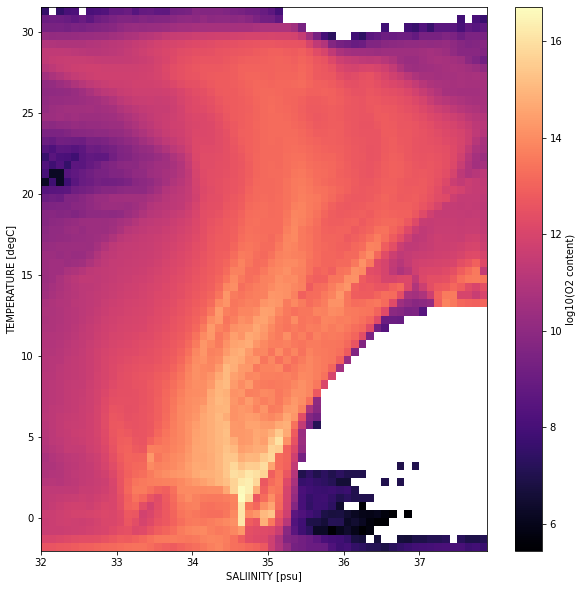

In [89]:
fig,ax = plt.subplots(figsize=(10,10))
x = hs['so_bin']
y = hs['thetao_bin']
c = np.log10(hs.mean('time'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='magma')
ax.set_xlabel('SALIINITY [psu]')
ax.set_ylabel('TEMPERATURE [degC]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('log10(O2 content)')

#### Change over time

Text(0, 0.5, 'Delta O2 content [mol s-1]')

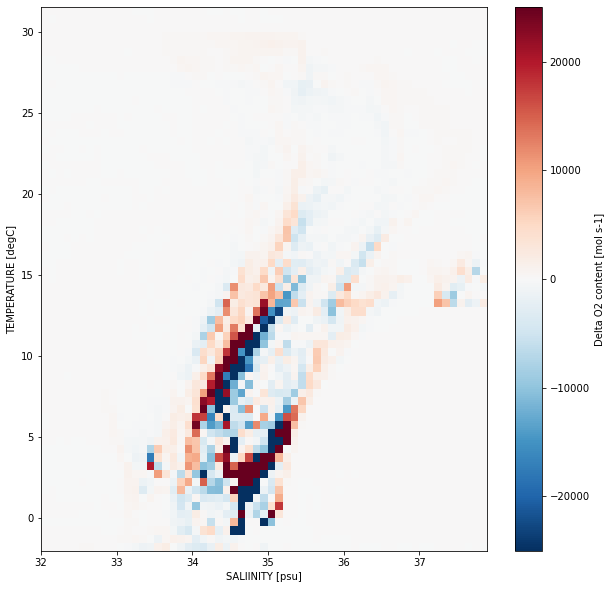

In [90]:
fig,ax = plt.subplots(figsize=(10,10))
x = hs['so_bin']
y = hs['thetao_bin']
te = slice(-20,-1)
ts = slice(0,20)
dt = hs['time'].isel(time=te).mean('time') - hs['time'].isel(time=ts).mean('time')
c = (hs.isel(time=te).mean('time') - hs.isel(time=ts).mean('time'))/((dt*1e-9).values.astype('float'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='RdBu_r',vmin=-0.25e5,vmax=0.25e5)
ax.set_xlabel('SALIINITY [psu]')
ax.set_ylabel('TEMPERATURE [degC]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('Delta O2 content [mol s-1]')

In [83]:
dt*1e-9/31536000

<xarray.DataArray 'time' ()>
array(144, dtype='timedelta64[ns]')